In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from functools import reduce
import numpy as np
import pandas as pd
from time import time
from imgfeature import ImFeature, ResizeImFeature, CropImFeature, ImSim
import gc
import matplotlib.pyplot as plt

In [2]:
def imhash(gray):
    dt = gray.flatten()
    xlen = len(dt)
    avg = dt.mean()
    avg_list = ['0' if i < avg else '1' for i in dt]
    return ''.join(['%x' % int(''.join(avg_list[x: x+4]), 2) for x in range(0, xlen, 4)])

def hamming(hash1, hash2):
    len1 = len(hash1)
    len2 = len(hash2)
    hlen = 0
    if len1 < len2:
        hlen = len1
    else:
        hlen = len2
    if hlen == 0:
        return -1
    distance = 0
    for i in range(hlen):
        num1 = int(hash1[i], 16)
        num2 = int(hash2[i], 16)
        xor_num = num1 ^ num2
        for i in [1, 2, 4, 8]:
            if i & xor_num != 0:
                distance += 1
    return distance

def genhash(df, size):
    imf_resize = ResizeImFeature(k=50)
    img_paths = df['path']
    fp_hashes = list()

    start = time()

    for img_path in img_paths:
        bgr, gray = imf_resize.read(img_path, size)
        fp_hash = imhash(gray)
        fp_hashes.append(fp_hash)

    print('cost time: {}s'.format(time() - start))
    return fp_hashes

In [3]:
dataset = pd.read_csv('dataset.csv')
df = pd.read_csv('dataset_with_fp_long.csv')

In [66]:
imgs = [{'img_index': 63441, 'path': 'images/train/客厅_北欧极简/804814_3897668.jpg', 'sim': 0.72}, {'img_index': 97943, 'path': 'images/train/餐厅_北欧极简/1096774_5725878.jpg', 'sim': 0.66}, {'img_index': 99170, 'path': 'images/train/餐厅_北欧极简/522018_2153111.jpg', 'sim': 0.7}, {'img_index': 99834, 'path': 'images/train/餐厅_北欧极简/594735_2608294.jpg', 'sim': 0.58}, {'img_index': 99960, 'path': 'images/train/餐厅_北欧极简/601830_2649315.jpg', 'sim': 0.74}, {'img_index': 100000, 'path': 'images/train/餐厅_北欧极简/605633_2670717.jpg', 'sim': 1.0}, {'img_index': 104624, 'path': 'images/train/餐厅_现代简约/1130562_5927347.jpg', 'sim': 0.64}, {'img_index': 108677, 'path': 'images/train/餐厅_现代简约/580096_2515131.jpg', 'sim': 0.72}, {'img_index': 109338, 'path': 'images/train/餐厅_现代简约/615001_2725105.jpg', 'sim': 0.72}]
imgs = sorted(imgs, key=lambda x:x['sim'], reverse=True)

sim_imgs_df = pd.DataFrame(imgs)

In [15]:
def genhash_batch(batches):
    for hash_size in batches:
        print('gen hash {}'.format(hash_size))

        fp_hashes = genhash(dataset, hash_size)

        dataset['fp_hash{}'.format(hash_size)] = fp_hashes

        dataset.to_csv('dataset_with_fp_hash{}.csv'.format(hash_size), index=False)

In [16]:
genhash_batch([20, 32, 40])

gen hash 20
cost time: 2222.089304447174s
gen hash 32
cost time: 2344.566497564316s
gen hash 40
cost time: 2447.8775703907013s


In [19]:
df_allhash = pd.read_csv('dataset_with_fp_hash40.csv')

In [22]:
len(df_allhash['fp_hash16'][0])

64

In [23]:
hash_size = 4

fp_val_hashes = genhash(dataset, hash_size)

cost time: 2320.712691783905s


In [25]:
int(fp_val_hashes[0], 16)

60424

In [26]:
fp_val_hashes[0]

'ec08'

In [27]:
dataset_short_hash = pd.read_csv('dataset.csv')

In [32]:
dataset_short_hash.head()

,path,type,style,hash_short,hash_int16
0,images/train/书房_中式传统/1005641_5145421.jpg,书房,中式传统,ec08,60424
1,images/train/书房_中式传统/1014492_5201166.jpg,书房,中式传统,b39e,45982
2,images/train/书房_中式传统/1016915_5218514.jpg,书房,中式传统,3543,13635
3,images/train/书房_中式传统/1017498_5222363.jpg,书房,中式传统,ee23,60963
4,images/train/书房_中式传统/1017498_5222364.jpg,书房,中式传统,7ec9,32457


In [29]:
dataset_short_hash['hash_short'] = fp_val_hashes

In [31]:
dataset_short_hash['hash_int16'] = [int(h, 16) for h in fp_val_hashes]

In [33]:
dataset_short_hash.tail()

,path,type,style,hash_short,hash_int16
113886,images/train/餐厅_美式经典/995746_5084211.jpg,餐厅,美式经典,ff69,65385
113887,images/train/餐厅_美式经典/996069_5086370.jpg,餐厅,美式经典,cbd5,52181
113888,images/train/餐厅_美式经典/996069_5086377.jpg,餐厅,美式经典,bc58,48216
113889,images/train/餐厅_美式经典/996237_5087392.jpg,餐厅,美式经典,aec5,44741
113890,images/train/餐厅_美式经典/996237_5087393.jpg,餐厅,美式经典,fdc3,64963


In [34]:
int('cbd5', 16)

52181

In [35]:
dataset_short_hash_sort = dataset_short_hash.sort_values(by=['hash_int16'])

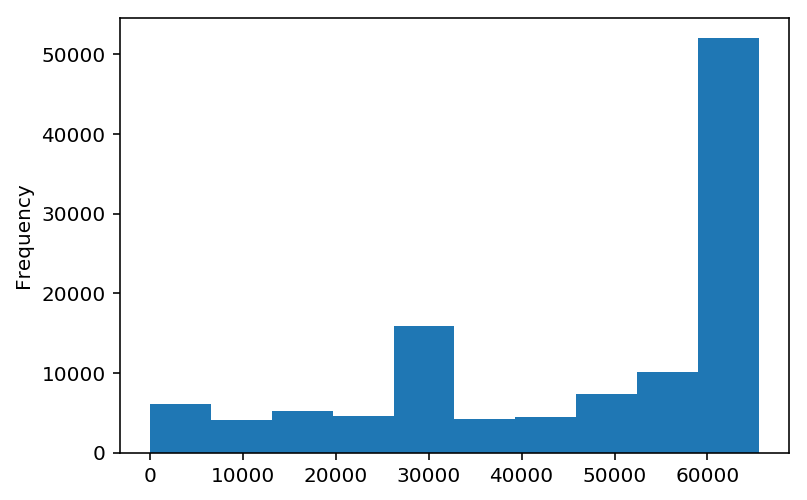

In [55]:
dataset_short_hash['hash_int16'].plot.hist()

In [62]:
dataset_short_hash.corr().abs()

,hash_int16
hash_int16,1.0


In [72]:
dataset_short_hash_sort.loc[sim_imgs_df['img_index']]

,path,type,style,hash_short,hash_int16
100000,images/train/餐厅_北欧极简/605633_2670717.jpg,餐厅,北欧极简,fd90,64912
99960,images/train/餐厅_北欧极简/601830_2649315.jpg,餐厅,北欧极简,fd90,64912
63441,images/train/客厅_北欧极简/804814_3897668.jpg,客厅,北欧极简,fd90,64912
108677,images/train/餐厅_现代简约/580096_2515131.jpg,餐厅,现代简约,fd90,64912
109338,images/train/餐厅_现代简约/615001_2725105.jpg,餐厅,现代简约,fd90,64912
99170,images/train/餐厅_北欧极简/522018_2153111.jpg,餐厅,北欧极简,fd90,64912
97943,images/train/餐厅_北欧极简/1096774_5725878.jpg,餐厅,北欧极简,fd90,64912
104624,images/train/餐厅_现代简约/1130562_5927347.jpg,餐厅,现代简约,fd90,64912
99834,images/train/餐厅_北欧极简/594735_2608294.jpg,餐厅,北欧极简,fd90,64912


In [73]:
dataset_short_hash_sort[dataset_short_hash_sort['hash_int16'] == 64912]

,path,type,style,hash_short,hash_int16
15102,images/train/卧室_北欧极简/584573_2544823.jpg,卧室,北欧极简,fd90,64912
57977,images/train/客厅_北欧极简/1113007_5826678.jpg,客厅,北欧极简,fd90,64912
100822,images/train/餐厅_北欧极简/826918_4027976.jpg,餐厅,北欧极简,fd90,64912
58167,images/train/客厅_北欧极简/1198111_6329488.jpg,客厅,北欧极简,fd90,64912
73599,images/train/客厅_现代简约/1737821_9463079.jpg,客厅,现代简约,fd90,64912
74581,images/train/客厅_现代简约/498238_2004940.jpg,客厅,现代简约,fd90,64912
74393,images/train/客厅_现代简约/494628_1983806.jpg,客厅,现代简约,fd90,64912
100904,images/train/餐厅_北欧极简/872497_4316124.jpg,餐厅,北欧极简,fd90,64912
61824,images/train/客厅_北欧极简/603335_2657409.jpg,客厅,北欧极简,fd90,64912
104624,images/train/餐厅_现代简约/1130562_5927347.jpg,餐厅,现代简约,fd90,64912


In [37]:
from PIL import Image

In [43]:
img1 = Image.open('images/train/卫生间_现代简约/601942_2649992.jpg')

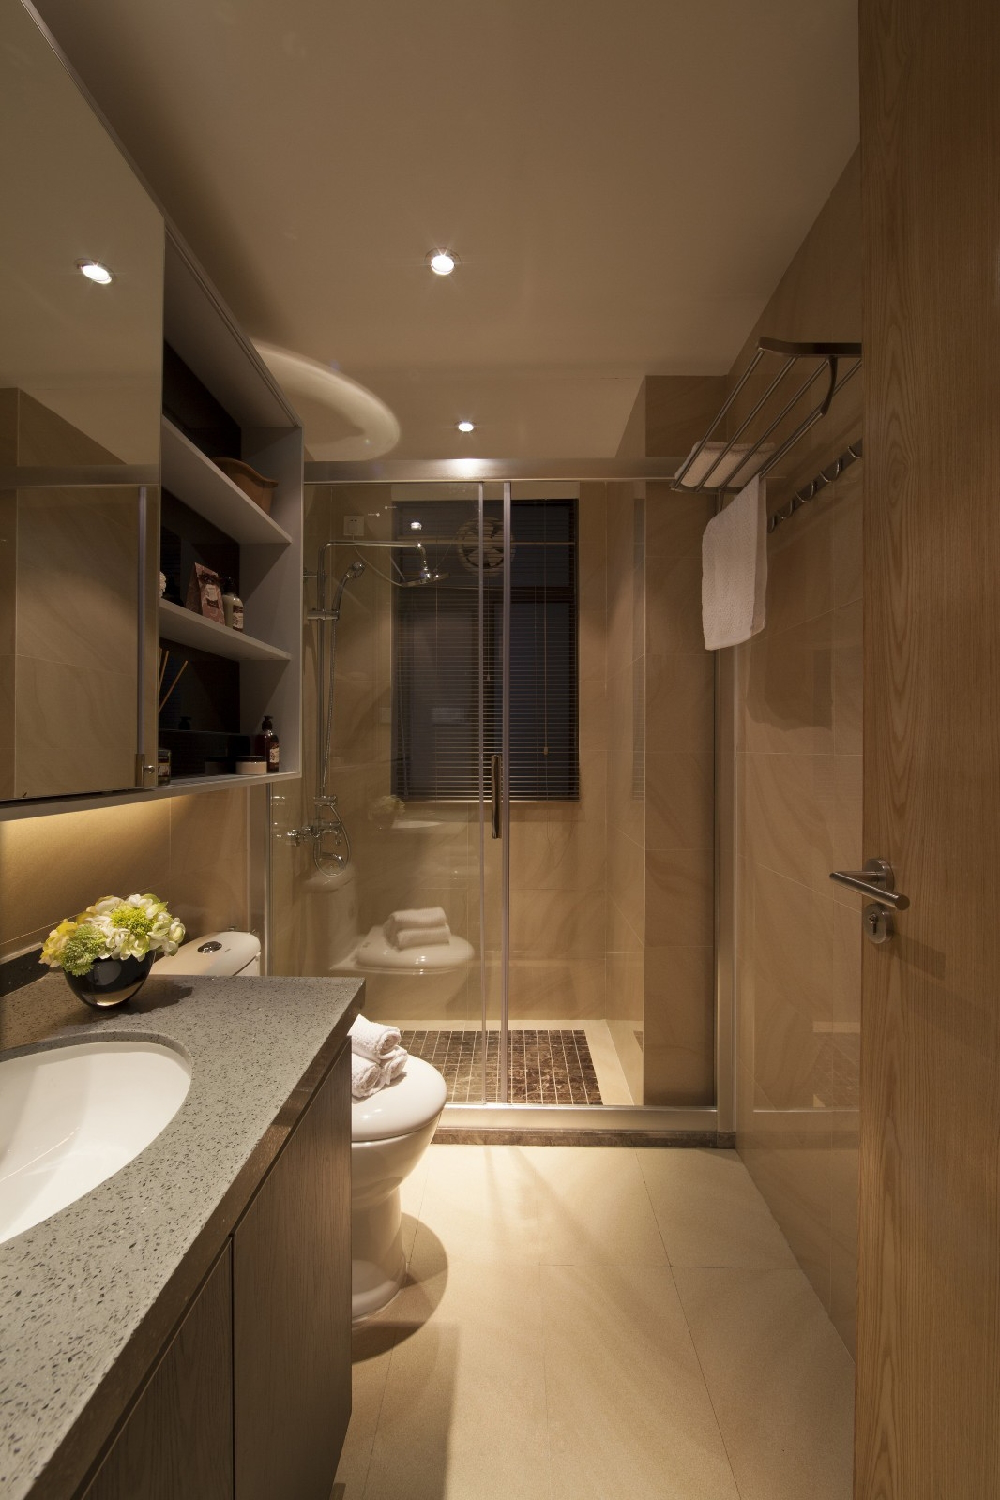

In [44]:
img1

In [46]:
img1 = Image.open('images/train/阳台_地中海/569085_2443429.jpg')

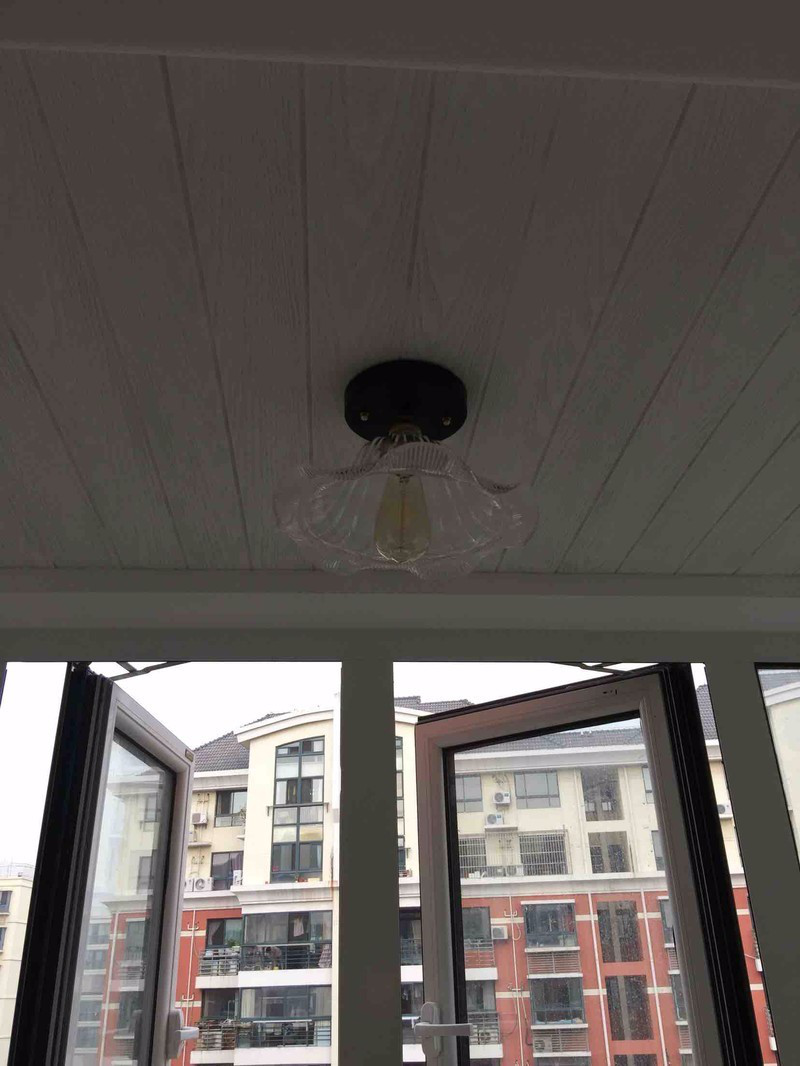

In [47]:
img1

In [57]:
bin(60000)

'0b1110101001100000'

In [75]:
# dataset_short_hash.to_csv('dataset_hash_int16.csv', index=False)

In [76]:
dataset_short_hash.head()

,path,type,style,hash_short,hash_int16
0,images/train/书房_中式传统/1005641_5145421.jpg,书房,中式传统,ec08,60424
1,images/train/书房_中式传统/1014492_5201166.jpg,书房,中式传统,b39e,45982
2,images/train/书房_中式传统/1016915_5218514.jpg,书房,中式传统,3543,13635
3,images/train/书房_中式传统/1017498_5222363.jpg,书房,中式传统,ee23,60963
4,images/train/书房_中式传统/1017498_5222364.jpg,书房,中式传统,7ec9,32457


In [91]:
all_item = list()

start = time()
for index in dataset_short_hash.index:
    if dataset_short_hash.loc[index].hash_short == 'fdc3':
        all_item.append(index)

print('cost time: {} s'.format(time() - start))

cost time: 18.49770951271057 s


In [92]:
all_item = list()

start = time()
for i, hash_short in enumerate(dataset_short_hash['hash_short']):
    if hash_short == 'fdc3':
        all_item.append(i)

print('cost time: {} s'.format(time() - start))

cost time: 0.018927335739135742 s


In [93]:
all_item

[71797,
 100896,
 110721,
 112235,
 112487,
 113155,
 113299,
 113601,
 113695,
 113825,
 113890]

In [88]:
dataset_short_hash.loc[0].path

'images/train/书房_中式传统/1005641_5145421.jpg'